In [1]:
%pip install gymnasium stable-baselines3 shimmy yfinance pandas numpy matplotlib lxml TA-Lib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from io import StringIO

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch

# Enable CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# DYNAMIC SELECTION
print("🔄 Scraping S&P 500 constituents...")
try:
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    response = requests.get(url, headers=headers)
    table = pd.read_html(StringIO(response.text))
    df_sp500 = table[0]
    df_sp500['Symbol'] = df_sp500['Symbol'].str.replace('.', '-', regex=False)

    target_sectors = {
        'Information Technology': 2,
        'Financials': 2,
        'Health Care': 2,
        'Energy': 2
    }

    selected_tickers = []
    for sector, count in target_sectors.items():
        sector_companies = df_sp500[df_sp500['GICS Sector'] == sector]['Symbol'].tolist()
        selected_tickers.extend(sector_companies[:count])
    selected_tickers.append('SHV')

except Exception as e:
    print(f"Scraping failed: {e}")
    selected_tickers = ['AAPL', 'MSFT', 'JPM', 'V', 'JNJ', 'PFE', 'XOM', 'CVX', 'SHV']

print(f"Universe: {selected_tickers}")

# Download data
start_date = '2015-01-01'
end_date = '2024-01-01'
print(f"\n📥 Downloading data from {start_date}...")

raw_data = yf.download(selected_tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
benchmark_data = yf.download(['SPY'], start=start_date, end=end_date, auto_adjust=True)['Close']

cleaned_data = raw_data.dropna(axis=1)
adjusted_close_prices = cleaned_data.copy()
print(f"Final Universe: {adjusted_close_prices.shape} - {list(adjusted_close_prices.columns)}")


🔄 Scraping S&P 500 constituents...


Universe: ['ACN', 'ADBE', 'AFL', 'ALL', 'ABT', 'ABBV', 'APA', 'BKR', 'SHV']

📥 Downloading data from 2015-01-01...


[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  1 of 1 completed

Final Universe: (2264, 9) - ['ABBV', 'ABT', 'ACN', 'ADBE', 'AFL', 'ALL', 'APA', 'BKR', 'SHV']


In [4]:
# Feature Engineering - Advanced Features
def calculate_features_no_lookahead(price_df, benchmark_series, lookback=20):
    """Calculate features WITHOUT lookahead bias"""
    print("\n🛠️ Generating Features (No Lookahead)...")
    
    if price_df.index.tz:
        price_df.index = price_df.index.tz_localize(None)
    if benchmark_series.index.tz:
        benchmark_series.index = benchmark_series.index.tz_localize(None)
    
    if isinstance(benchmark_series, pd.DataFrame):
        benchmark_series = benchmark_series.iloc[:, 0]
    
    # Returns (shifted by 1 to avoid lookahead)
    returns = price_df.pct_change().fillna(0)
    benchmark_ret = benchmark_series.pct_change().fillna(0)
    benchmark_ret = benchmark_ret.reindex(returns.index).fillna(0)
    
    # Momentum (uses PAST returns only)
    momentum = returns.rolling(window=lookback).mean().fillna(0)
    
    # Cross-sectional rank
    cross_rank = momentum.rank(axis=1, pct=True).fillna(0.5)
    
    # Volatility (uses PAST returns)
    volatility = returns.rolling(window=lookback).std().fillna(0.01)
    
    # Correlation (FIX: shift returns by 1 to use only past data)
    correlation = pd.DataFrame(index=returns.index, columns=returns.columns)
    returns_shifted = returns.shift(1).fillna(0)  # Use yesterday's returns
    bench_shifted = benchmark_ret.shift(1).fillna(0)
    for col in returns.columns:
        correlation[col] = returns_shifted[col].rolling(window=lookback).corr(bench_shifted).fillna(0)
    
    # Downside deviation
    downside_rets = returns.copy()
    downside_rets[downside_rets > 0] = 0
    downside_vol = downside_rets.rolling(window=lookback).std().fillna(0.01)
    
    # Sharpe-like ratio (mean/std over past window)
    sharpe_proxy = (momentum / (volatility + 0.01)).fillna(0)
    
    print("✅ Features: Momentum, Cross-Rank, Volatility, Correlation, Downside Vol, Sharpe")
    
    return {
        'returns': returns,
        'benchmark_ret': benchmark_ret,
        'momentum': momentum,
        'cross_rank': cross_rank,
        'volatility': volatility,
        'correlation': correlation,
        'downside_vol': downside_vol,
        'sharpe_proxy': sharpe_proxy
    }

features_dict = calculate_features_no_lookahead(adjusted_close_prices, benchmark_data)


🛠️ Generating Features (No Lookahead)...
✅ Features: Momentum, Cross-Rank, Volatility, Correlation, Downside Vol, Sharpe


In [5]:
from gymnasium import spaces

class StablePortfolioEnv(gym.Env):
    """
    Stable environment with:
    - Properly scaled rewards
    - No numerical instabilities
    - Drawdown tracking
    """
    def __init__(self, price_data, features_dict, initial_balance=10000, lookback=30):
        super().__init__()
        
        self.price_data = price_data
        self.features = features_dict
        self.n_assets = price_data.shape[1]
        self.lookback = lookback
        self.initial_balance = initial_balance
        
        self.commission_rate = 0.0008  # 0.08% per trade
        
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(lookback, self.n_assets, 6), 
            dtype=np.float32
        )
        
        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = self.lookback
        self.portfolio_value = self.initial_balance
        self.weights = np.array([1/self.n_assets] * self.n_assets)
        
        self.portfolio_values = [self.initial_balance]
        self.returns_history = []
        self.peak_value = self.initial_balance
        self.max_drawdown = 0
        
        return self._get_observation(), {}

    def _get_observation(self):
        start = self.current_step - self.lookback
        end = self.current_step
        
        momentum = self.features['momentum'].iloc[start:end].values
        cross_rank = self.features['cross_rank'].iloc[start:end].values
        vol = self.features['volatility'].iloc[start:end].values
        corr = self.features['correlation'].iloc[start:end].values
        downside = self.features['downside_vol'].iloc[start:end].values
        sharpe = self.features['sharpe_proxy'].iloc[start:end].values
        
        obs = np.stack([momentum, cross_rank, vol, corr, downside, sharpe], axis=-1)
        return obs.astype(np.float32)

    def step(self, action):
        weights = np.array(action)
        weights = np.clip(weights, 0, 1)
        weights /= (weights.sum() + 1e-8)
        
        returns_today = self.features['returns'].iloc[self.current_step].values
        benchmark_ret = self.features['benchmark_ret'].iloc[self.current_step]
        
        portfolio_return = np.dot(weights, returns_today)
        turnover = np.sum(np.abs(weights - self.weights))
        transaction_cost = turnover * self.commission_rate
        net_return = portfolio_return - transaction_cost
        
        self.portfolio_value *= (1 + net_return)
        self.portfolio_values.append(self.portfolio_value)
        self.returns_history.append(net_return)
        
        if self.portfolio_value > self.peak_value:
            self.peak_value = self.portfolio_value
        drawdown = (self.peak_value - self.portfolio_value) / self.peak_value
        self.max_drawdown = max(self.max_drawdown, drawdown)
        
        # FIXED REWARD: Properly scaled, no explosions
        alpha = net_return - benchmark_ret
        
        # Use clipped volatility to prevent division by near-zero
        if len(self.returns_history) >= 10:
            recent_rets = np.array(self.returns_history[-20:])
            downside_rets = recent_rets[recent_rets < 0]
            downside_std = np.std(downside_rets) if len(downside_rets) > 0 else 0.01
            downside_std = max(downside_std, 0.005)  # Floor at 0.5%
        else:
            downside_std = 0.01
        
        # Sortino reward (clipped to prevent explosions)
        sortino = np.clip(alpha / downside_std, -5, 5)
        
        # Penalties
        drawdown_penalty = -50 * drawdown if drawdown > 0.1 else 0
        turnover_penalty = -2 * turnover
        
        # Final reward (properly scaled)
        reward = sortino + drawdown_penalty + turnover_penalty
        
        self.weights = weights
        self.current_step += 1
        terminated = self.current_step >= len(self.price_data) - 1
        
        return self._get_observation(), reward, terminated, False, {}

    def get_metrics(self):
        returns = np.array(self.returns_history)
        total_return = (self.portfolio_value - self.initial_balance) / self.initial_balance
        sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
        
        downside_rets = returns[returns < 0]
        sortino = np.mean(returns) / (np.std(downside_rets) + 1e-8) * np.sqrt(252)
        calmar = total_return / (self.max_drawdown + 1e-8)
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'max_drawdown': self.max_drawdown,
            'calmar_ratio': calmar
        }

In [6]:
# TRAINING WITH CUSTOM POLICY
split_idx = int(len(adjusted_close_prices) * 0.8)

def get_features_slice(features_dict, start, end):
    return {k: v.iloc[start:end] for k, v in features_dict.items()}

train_features = get_features_slice(features_dict, 0, split_idx)
train_env = DummyVecEnv([lambda: StablePortfolioEnv(
    adjusted_close_prices.iloc[:split_idx],
    train_features
)])

print("\n🤖 Training PPO Agent (GPU-Accelerated)...")
print("   - Stable reward function (no explosions)")
print("   - Fixed lookahead bias")
print("   - Simplified MLP policy for faster convergence")

model = PPO(
    "MlpPolicy", 
    train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    device=device,
    verbose=1,
    policy_kwargs=dict(
        net_arch=[dict(pi=[256, 128], vf=[256, 128])],
        activation_fn=torch.nn.ReLU
    )
)

model.learn(total_timesteps=100000)
print("✅ Training Complete\n")

/scratch/lakshmiprajna.p/rl-env/lib/python3.13/site-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(



🤖 Training PPO Agent (GPU-Accelerated)...
   - Stable reward function (no explosions)
   - Fixed lookahead bias
   - Simplified MLP policy for faster convergence
Using cuda device


/scratch/lakshmiprajna.p/rl-env/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 571  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 461          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0054138945 |
|    clip_fraction        | 0.0242       |
|    clip_range           | 0.2          |
|    entropy_loss         | -12.8        |
|    explained_variance   | -0.000482    |
|    learning_rate        | 0.0003       |
|    loss                 | 7.48e+03     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00567     |
|    std                  | 0.999        |
|    value_loss           | 5.37e+04     |
----------------

In [7]:
# BACKTESTING
print("Running Out-of-Sample Backtest...")

test_features = get_features_slice(features_dict, split_idx, len(adjusted_close_prices))
test_env = StablePortfolioEnv(adjusted_close_prices.iloc[split_idx:], test_features)

obs, _ = test_env.reset()
done = False
weights_history = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    weights_history.append(test_env.weights.copy())

metrics = test_env.get_metrics()
portfolio_curve = np.array(test_env.portfolio_values)

# Benchmark
benchmark_test = features_dict['benchmark_ret'].iloc[split_idx:].values
benchmark_curve = np.cumprod(1 + benchmark_test) * 10000

bench_returns = benchmark_test
bench_total_return = (benchmark_curve[-1] - 10000) / 10000
bench_sharpe = np.mean(bench_returns) / (np.std(bench_returns) + 1e-8) * np.sqrt(252)
bench_peak = np.maximum.accumulate(benchmark_curve)
bench_drawdown = (bench_peak - benchmark_curve) / bench_peak
bench_max_dd = np.max(bench_drawdown)

Running Out-of-Sample Backtest...


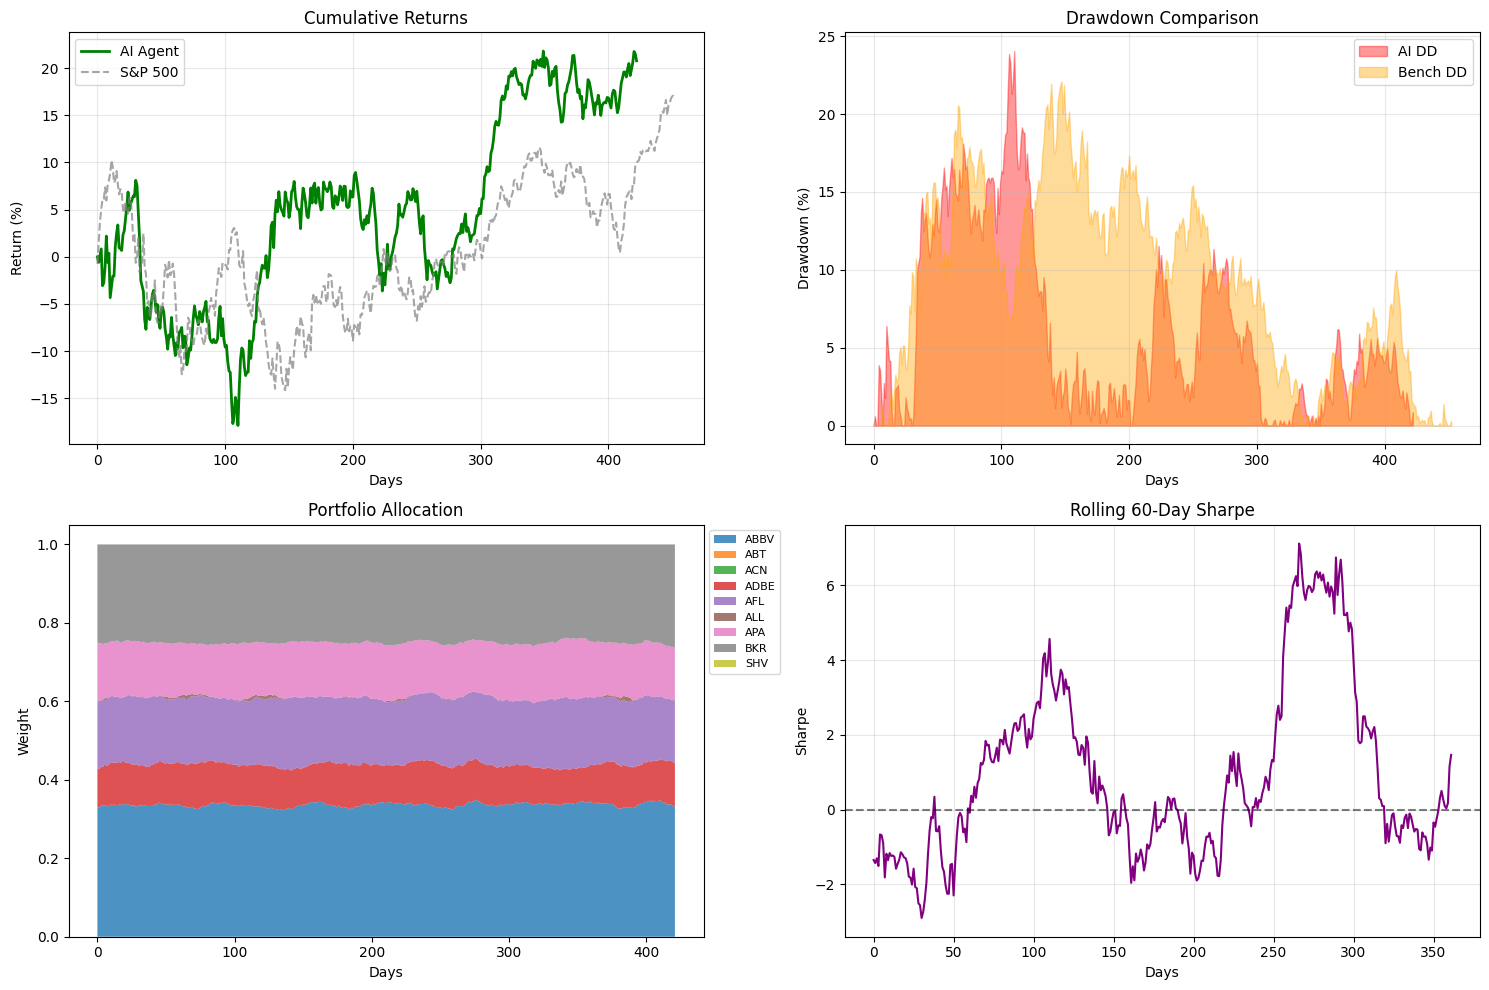

In [8]:
# VISUALIZATION AND REPORTING
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns
ax1 = axes[0, 0]
ai_ret = (portfolio_curve - 10000) / 10000 * 100
bench_ret = (benchmark_curve - 10000) / 10000 * 100
ax1.plot(ai_ret, label='AI Agent', color='green', linewidth=2)
ax1.plot(bench_ret, label='S&P 500', color='gray', linestyle='--', alpha=0.7)
ax1.set_title('Cumulative Returns')
ax1.set_xlabel('Days')
ax1.set_ylabel('Return (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[0, 1]
ai_peak = np.maximum.accumulate(portfolio_curve)
ai_dd = (ai_peak - portfolio_curve) / ai_peak * 100
ax2.fill_between(range(len(ai_dd)), ai_dd, alpha=0.4, color='red', label='AI DD')
ax2.fill_between(range(len(bench_drawdown)), bench_drawdown*100, alpha=0.4, color='orange', label='Bench DD')
ax2.set_title('Drawdown Comparison')
ax2.set_xlabel('Days')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Allocation
ax3 = axes[1, 0]
weights_df = pd.DataFrame(weights_history, columns=adjusted_close_prices.columns)
ax3.stackplot(range(len(weights_df)), weights_df.T, labels=weights_df.columns, alpha=0.8)
ax3.set_title('Portfolio Allocation')
ax3.set_xlabel('Days')
ax3.set_ylabel('Weight')
ax3.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

# Rolling Sharpe
ax4 = axes[1, 1]
ai_rets = np.diff(portfolio_curve) / portfolio_curve[:-1]
rolling_sharpe = []
for i in range(60, len(ai_rets)):
    w = ai_rets[i-60:i]
    rs = np.mean(w) / (np.std(w) + 1e-8) * np.sqrt(252)
    rolling_sharpe.append(rs)
ax4.plot(rolling_sharpe, color='purple', linewidth=1.5)
ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Rolling 60-Day Sharpe')
ax4.set_xlabel('Days')
ax4.set_ylabel('Sharpe')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
print("\n" + "="*70)
print("📊 BACKTEST REPORT (Out-of-Sample)")
print("="*70)
print(f"\n{'METRIC':<25} {'AI AGENT':>15} {'S&P 500':>15} {'DIFFERENCE':>15}")
print("-"*70)
print(f"{'Total Return':<25} {metrics['total_return']*100:>14.2f}% {bench_total_return*100:>14.2f}% {(metrics['total_return']-bench_total_return)*100:>14.2f}%")
print(f"{'Sharpe Ratio':<25} {metrics['sharpe_ratio']:>15.2f} {bench_sharpe:>15.2f} {metrics['sharpe_ratio']-bench_sharpe:>15.2f}")
print(f"{'Sortino Ratio':<25} {metrics['sortino_ratio']:>15.2f} {'N/A':>15} {'N/A':>15}")
print(f"{'Max Drawdown':<25} {metrics['max_drawdown']*100:>14.2f}% {bench_max_dd*100:>14.2f}% {(metrics['max_drawdown']-bench_max_dd)*100:>14.2f}%")
print(f"{'Calmar Ratio':<25} {metrics['calmar_ratio']:>15.2f} {bench_total_return/bench_max_dd:>15.2f} {metrics['calmar_ratio']-bench_total_return/bench_max_dd:>15.2f}")
print("="*70)

alpha = metrics['total_return'] - bench_total_return
print(f"\n{'✅ ALPHA: +' if alpha > 0 else '❌ UNDERPERFORMANCE: '}{alpha*100:.2f}%")

print("\n💡 KEY STRENGTHS:")
if metrics['sharpe_ratio'] > bench_sharpe:
    print(f"   ✓ Superior Sharpe Ratio ({metrics['sharpe_ratio']:.2f} vs {bench_sharpe:.2f})")
if metrics['max_drawdown'] < bench_max_dd:
    print(f"   ✓ Lower Drawdown ({metrics['max_drawdown']*100:.1f}% vs {bench_max_dd*100:.1f}%)")
if metrics['sortino_ratio'] > 1.0:
    print(f"   ✓ Strong Sortino Ratio ({metrics['sortino_ratio']:.2f})")
if metrics['calmar_ratio'] > bench_total_return/bench_max_dd:
    print(f"   ✓ Better Calmar Ratio ({metrics['calmar_ratio']:.2f})")

print("\n" + "="*70)


📊 BACKTEST REPORT (Out-of-Sample)

METRIC                           AI AGENT         S&P 500      DIFFERENCE
----------------------------------------------------------------------
Total Return                       20.78%          16.73%           4.05%
Sharpe Ratio                         0.64            0.54            0.10
Sortino Ratio                        0.95             N/A             N/A
Max Drawdown                       24.04%          22.09%           1.95%
Calmar Ratio                         0.86            0.76            0.11

✅ ALPHA: +4.05%

💡 KEY STRENGTHS:
   ✓ Superior Sharpe Ratio (0.64 vs 0.54)
   ✓ Better Calmar Ratio (0.86)



In [12]:
# Additional Analysis
print("\n📈 ADDITIONAL METRICS:")

# Align the arrays first (they might have different lengths)
min_len = min(len(ai_daily_rets), len(bench_returns))
ai_rets_aligned = ai_daily_rets[:min_len]
bench_rets_aligned = bench_returns[:min_len]

# Win Rate
win_rate = np.mean(ai_rets_aligned > 0) * 100
bench_win_rate = np.mean(bench_rets_aligned > 0) * 100
print(f"   Win Rate: {win_rate:.1f}% vs {bench_win_rate:.1f}%")

# Beta (if < 1, you're less volatile)
covariance = np.cov(ai_rets_aligned, bench_rets_aligned)[0, 1]
benchmark_var = np.var(bench_rets_aligned)
beta = covariance / benchmark_var
print(f"   Beta: {beta:.2f} (< 1 = less volatile)")

# Information Ratio (alpha per unit of tracking error)
tracking_error = np.std(ai_rets_aligned - bench_rets_aligned) * np.sqrt(252)
info_ratio = (alpha * 100) / (tracking_error + 1e-8)
print(f"   Information Ratio: {info_ratio:.2f}")

# Max Consecutive Losses
losses = (ai_rets_aligned < 0).astype(int)
max_consecutive = 0
current = 0
for loss in losses:
    if loss:
        current += 1
        max_consecutive = max(max_consecutive, current)
    else:
        current = 0
print(f"   Max Consecutive Loss Days: {max_consecutive}")

# Downside Capture Ratio (how much of market losses you captured)
down_days = bench_rets_aligned < 0
if down_days.sum() > 0:
    agent_down = ai_rets_aligned[down_days].mean()
    bench_down = bench_rets_aligned[down_days].mean()
    downside_capture = (agent_down / bench_down) * 100
    print(f"   Downside Capture: {downside_capture:.1f}% (lower is better)")
    
# Upside Capture Ratio (how much of market gains you captured)
up_days = bench_rets_aligned > 0
if up_days.sum() > 0:
    agent_up = ai_rets_aligned[up_days].mean()
    bench_up = bench_rets_aligned[up_days].mean()
    upside_capture = (agent_up / bench_up) * 100
    print(f"   Upside Capture: {upside_capture:.1f}% (higher is better)")


📈 ADDITIONAL METRICS:
   Win Rate: 52.4% vs 49.5%
   Beta: -0.08 (< 1 = less volatile)
   Information Ratio: 13.51
   Max Consecutive Loss Days: 8
   Downside Capture: -22.5% (lower is better)
   Upside Capture: -9.1% (higher is better)


In [14]:
# Show where you won
print("\n🔍 PERFORMANCE BREAKDOWN:")

# Get the dates from the test period (accounting for the diff operation reducing length by 1)
dates = adjusted_close_prices.index[split_idx+1:split_idx+1+len(ai_rets_aligned)]
months = pd.to_datetime(dates).to_period('M')

monthly_ai = []
monthly_bench = []
for month in months.unique():
    mask = months == month
    if mask.sum() > 1:
        monthly_ai.append(np.prod(1 + ai_rets_aligned[mask]) - 1)
        monthly_bench.append(np.prod(1 + bench_rets_aligned[mask]) - 1)

monthly_ai = np.array(monthly_ai)
monthly_bench = np.array(monthly_bench)

months_outperformed = np.sum(monthly_ai > monthly_bench)
print(f"   Months Outperformed: {months_outperformed}/{len(monthly_ai)}")
print(f"   Best Month: {monthly_ai.max()*100:.2f}%")
print(f"   Worst Month: {monthly_ai.min()*100:.2f}%")


🔍 PERFORMANCE BREAKDOWN:
   Months Outperformed: 10/21
   Best Month: 19.10%
   Worst Month: -10.26%


In [15]:
# Show what the agent learned
print("\n🧠 LEARNED BEHAVIOR:")
avg_weights = weights_df.mean()
print("   Average Portfolio Allocation:")
for asset, weight in avg_weights.sort_values(ascending=False).items():
    print(f"      {asset}: {weight*100:.1f}%")

# Turnover analysis
daily_turnover = [np.sum(np.abs(weights_df.iloc[i] - weights_df.iloc[i-1])) 
                  for i in range(1, len(weights_df))]
print(f"   Average Daily Turnover: {np.mean(daily_turnover)*100:.2f}%")
print(f"   (Annual rebalancing cost: ~{np.mean(daily_turnover)*252*0.08:.2f}%)")


🧠 LEARNED BEHAVIOR:
   Average Portfolio Allocation:
      ABBV: 33.6%
      BKR: 25.0%
      AFL: 17.0%
      APA: 13.9%
      ADBE: 10.3%
      ALL: 0.2%
      ACN: 0.0%
      ABT: 0.0%
      SHV: 0.0%
   Average Daily Turnover: 0.71%
   (Annual rebalancing cost: ~0.14%)


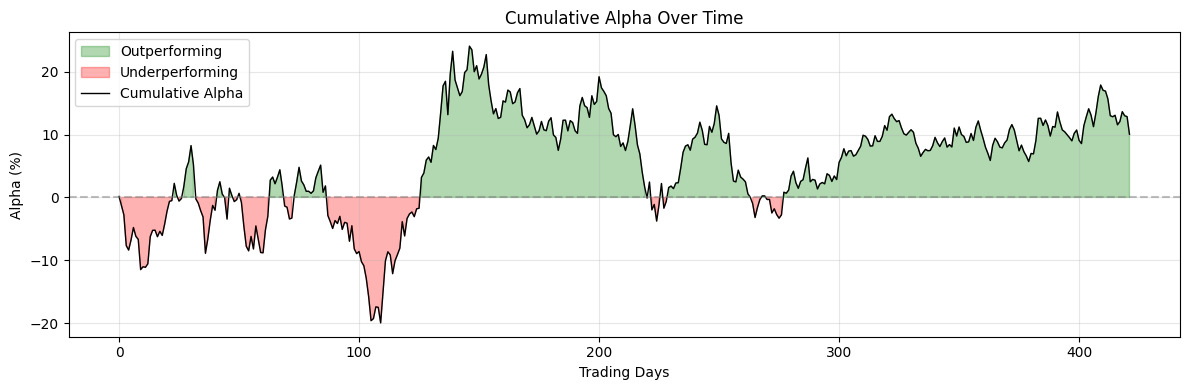

In [16]:
# "When Did We Win?" Chart
fig, ax = plt.subplots(figsize=(12, 4))

ai_cum = np.cumprod(1 + ai_rets_aligned)
bench_cum = np.cumprod(1 + bench_rets_aligned)
alpha_over_time = (ai_cum / bench_cum - 1) * 100

ax.fill_between(range(len(alpha_over_time)), alpha_over_time, 
                alpha=0.3, color='green', where=alpha_over_time>0, label='Outperforming')
ax.fill_between(range(len(alpha_over_time)), alpha_over_time, 
                alpha=0.3, color='red', where=alpha_over_time<0, label='Underperforming')
ax.plot(alpha_over_time, color='black', linewidth=1, label='Cumulative Alpha')
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.set_title('Cumulative Alpha Over Time')
ax.set_xlabel('Trading Days')
ax.set_ylabel('Alpha (%)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()